# True firing rates

Repeat for each layer

1. calculate spontaneous model's median fr. from l_i_ (NS_median)  
2. calculate in vivo model's median fr. from l_i: (M_median)  
3. calculate ground truth (GT) median FR from l_i: GT_median  
4. calculate true in vivo:  
  * median: GT_median + (M_median - NS_median)  
  * variance: GT_var + (M_var - NS_var)  

## Setup

activate spikebias env

In [41]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# SET PROJECT PATH

PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(PROJ_PATH)
from src.nodes.utils import get_config, savefig
from src.nodes.validation import firing_rate as fr
from src.nodes.analysis.npx_probe import true_fr
from src.nodes.postpro import metadata as meta
import spikeinterface as si
import shutil
from src.nodes.postpro import (
    cell_type,
)
import seaborn
import pandas
import numpy

from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


# SETUP EXPERIMENTS

# sorting extractors paths
SORTED_PATH_nv = "dataset/01_intermediate/sorting/marques/SortingKS4_10m" # marques-smith
SORTED_PATH_ns = "dataset/01_intermediate/sorting/npx_spont/SortingKS4_10m" # kilosort4 sorting npx spontaneous
GT_PATH_ns = "dataset/00_raw/ground_truth_npx_spont" # ground truth npx spontaneous

# intermediate data paths
LOG10_FR_PATH = "dataset/01_intermediate/true_firing_rates/log10_fr.csv"
RAW_FR_PATH = "dataset/01_intermediate/true_firing_rates/raw_fr.csv"
                
# PARAMETERS
SINGLE_UNIT = True
layers = ["L1", "L2/3", "L4", "L5", "L6"]

# SETUP PLOT 

DURATION = 600 # seconds

# set lognormal plot parameters
log_x_min = -3.0
log_x_max = 3.0
nbins = 30

# IF you don't want to use the feature, set the value to 1E100
# t_dec = 3600 # seconds until experimenter decides a cell is silent
t_dec = 1^100 # seconds until experimenter decides a cell is silent

cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 9  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.001}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# def save_SortingTrue_metadata(gt_path, blueconfig_path, duration, save):

#     # Get ground truth SortingExtractor
#     # - get first 10 minutes
#     SortingTrue = si.load_extractor(gt_path)
#     SortingTrue = SortingTrue.frame_slice(
#         start_frame=0, end_frame=duration * SortingTrue.sampling_frequency
#     )

#     # set unit features metadata (includes layer)
#     SortingTrue = cell_type.label_true_cell_properties(
#         SortingTrue, blueconfig_path, gt_path, save=False
#     )

#     # set unit firing rate metadata
#     SortingTrue = meta.set_firing_rates(SortingTrue, duration, gt_path, save=False)

#     # save
#     if save:
#         shutil.rmtree(GT_PATH_ns_10m, ignore_errors=True)
#         SortingTrue.save(folder=GT_PATH_ns_10m)
#     return SortingTrue

## Get metadata

In [10]:
# get sorted unit metadata
df_nv = fr.get_sorted_unit_meta(SORTED_PATH_nv)
df_ns = fr.get_sorted_unit_meta(SORTED_PATH_ns)

# keep units in cortex
df_nv = df_nv[np.isin(df_nv["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_ns = df_ns[np.isin(df_ns["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]

# unit-test: check all in cortex
assert all(
    np.isin(np.sort(df_nv["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_ns["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"

In [11]:
# unit-test ground truth metadata 
SortingTrue = si.load_extractor(GT_PATH_ns)
assert SortingTrue.get_property_keys()==['z',
 'layer',
 'orientation_w',
 'dynamics_resting_potential',
 'orientation_z',
 'layers',
 'exc_mini_frequency',
 'morph_class',
 'y',
 'inh_mini_frequency',
 'region',
 'me_combo',
 'synapse_class',
 'dynamics_input_resistance',
 'morphology',
 'etype',
 'model_type',
 'mtype',
 'x',
 'dynamics_threshold_current',
 'orientation_y',
 'model_template',
 'dynamics_holding_current',
 'orientation_x'], "wrong or missing ground truth metadata keys"

# load ground truth
SortingTrue = SortingTrue.frame_slice(start_frame=0, end_frame=DURATION * SortingTrue.sampling_frequency)

SortingTrue = meta.set_firing_rates(SortingTrue, DURATION, '', save=False)

In [12]:
# get ground truth metadata (and save)
# - save 10 minutes of ground truth sorting
# SortingTrue = save_SortingTrue_metadata(
#     GT_PATH_ns, cfg_ns["dataeng"]["blueconfig"], 10 * 60, save=True
# )
# df_gt_ns = meta.get_gt_unit_meta_df(GT_PATH_ns_10m)
df_gt_ns = meta.get_gt_unit_meta_df_from_extractor(SortingTrue)

# unit-test: check all in cortex
assert all(
    np.isin(np.sort(df_gt_ns["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"

### Curation or not

In [14]:
# curate units
if SINGLE_UNIT:
    df_nv = df_nv[df_nv["kslabel"] == "good"]
    df_ns = df_ns[df_ns["kslabel"] == "good"]
    print("single unit on.")

single unit on.


### Model's ground T. firing razes

* Sorted unit firing rates were calculated from the 10 first minutes of recording. We do the same for the ground truth.

### Save dataset

In [17]:
layers = ["L1", "L2/3", "L4", "L5", "L6"]

# log10
df_log_fr = true_fr.get_log10fr_df(df_nv, df_ns, df_gt_ns, layers, log=True)
df_log_fr.to_csv(LOG10_FR_PATH)

# raw
df_raw_fr = true_fr.get_log10fr_df(df_nv, df_ns, df_gt_ns, layers, log=False)
df_raw_fr.to_csv(RAW_FR_PATH)

In [24]:
display(df_log_fr)
display(df_raw_fr)

,firing rate,experiment,layer
284,-1.346787,GT,L1
96,-0.214670,NS,L1
285,0.669317,GT,L1
283,-0.273001,GT,L1
281,0.259275,GT,L1
...,...,...,...
1254,-0.926893,GT,L6
1255,-2.778151,GT,L6
1256,-1.574031,GT,L6
1249,-0.133713,GT,L6


,firing rate,experiment,layer
284,0.045000,GT,L1
96,0.610000,NS,L1
285,4.670000,GT,L1
283,0.533333,GT,L1
281,1.816667,GT,L1
...,...,...,...
1254,0.118333,GT,L6
1255,0.001667,GT,L6
1256,0.026667,GT,L6
1249,0.735000,GT,L6


In [25]:
# unit-testing
assert sum(df_log_fr["experiment"] == "GT") == sum(df_raw_fr["experiment"] == "GT")
assert sum(df_log_fr["experiment"] == "M") == sum(df_raw_fr["experiment"] == "M")

## Plot


In [ ]:
# set parameters
plot_scale = "log"
nbins = 31
kernel_w = 0.04


flt_fr = df_raw_fr.loc[df_raw_fr["experiment"].apply(lambda _x: _x in ["GT", "NS"])]
flt_log = flt_fr.copy(); flt_log["firing rate"] = numpy.log10(flt_log["firing rate"])



In [29]:
fr_bins = numpy.linspace(0, 10., nbins)
log_bins = numpy.linspace(-3, 1, nbins)

def gaussian_kernel_estimate(bins, rel_width):
    from scipy.stats import norm
    w = rel_width * (bins[-1] - bins[0])
    kernel = norm(0, w)
    bin_c = 0.5 * (bins[:-1] + bins[1:])
    def func(pts):
        ret = [kernel.pdf(bin_c - _pt) for _pt in pts]
        ret = numpy.nansum(numpy.vstack([_ret / _ret.sum() for _ret in ret]), axis=0)
        return pandas.Series(ret, index=bin_c)
    
    return func

fr_df = flt_fr.groupby(["experiment", "layer"])["firing rate"].apply(
    gaussian_kernel_estimate(fr_bins, kernel_w)
)
log_df = flt_log.groupby(["experiment", "layer"])["firing rate"].apply(
    gaussian_kernel_estimate(log_bins, kernel_w)
)

if plot_scale == "log":
    use_fr = flt_log
    use_df = log_df
else:
    use_fr = flt_fr
    use_df = fr_df
    
p_df = use_df.unstack("experiment").apply(lambda _row: _row["NS"]/(1E-1+_row["GT"]), axis=1).unstack("layer")

min_fr = use_fr.groupby(["layer"])["firing rate"].min()
max_fr = use_fr.groupby(["layer"])["firing rate"].max()
for col in min_fr.index:
    mn = min_fr[col]; mx = max_fr[col]
    p_df[col].loc[p_df.index < mn] = numpy.NaN
    p_df[col].loc[p_df.index > mx] = numpy.NaN
    

In [30]:
def estimate_average_ratio_bootstrap(smpls, n=100, m=100, func_agg=numpy.nanmean, func_cmp=lambda x, y: x/y):
    estimates = []
    smpls_a = numpy.array(smpls["GT"]); smpls_b = numpy.array(smpls["NS"])
    smpls_a = smpls_a[~numpy.isinf(smpls_a)]; smpls_b = smpls_b[~numpy.isinf(smpls_b)]
    for _ in range(n):
        a = numpy.random.choice(smpls_a, m)
        b = numpy.random.choice(smpls_b, m)
        estimates.append(func_cmp(func_agg(a), func_agg(b)))
    estimates = numpy.array(estimates); estimates = estimates[~numpy.isnan(estimates)]
    return pandas.Series({"5th": numpy.percentile(estimates, 5), "mean": numpy.mean(estimates),
                  "95th": numpy.percentile(estimates, 95)})

overest_df = flt_fr.groupby(["experiment", "layer"])["firing rate"].apply(list).unstack("experiment")
overest_df = overest_df.apply(estimate_average_ratio_bootstrap, axis=1, func_agg=numpy.nanmean)

overest_log = flt_log.groupby(["experiment", "layer"])["firing rate"].apply(list).unstack("experiment")
overest_log = overest_log.apply(estimate_average_ratio_bootstrap, axis=1, func_agg=numpy.nanmean, func_cmp=lambda x,y:x-y)

overest_pooled = estimate_average_ratio_bootstrap(flt_fr.set_index("experiment")["firing rate"],
                                 func_agg=numpy.nanmean)
overest_pooled_log = estimate_average_ratio_bootstrap(flt_log.set_index("experiment")["firing rate"],
                                 func_agg=numpy.nanmean, func_cmp=lambda x,y:x-y)

5th     0.153901
mean    0.220899
95th    0.292315
dtype: float64


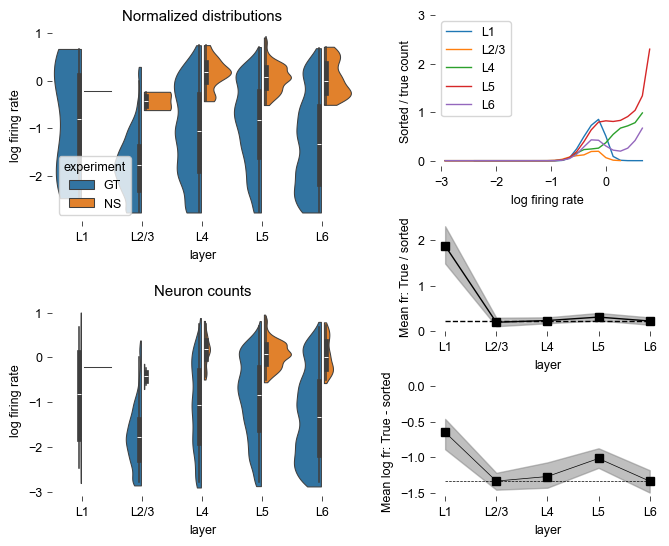

In [42]:
fig = plt.figure(figsize=(7.5, 5.5))

layout = [
    [0.05, 0.55, 0.4, 0.35],
    [0.05, 0.05, 0.4, 0.35],
    [0.56, 0.65, 0.3, 0.275],
    [0.56, 0.35, 0.3, 0.2],
    [0.56, 0.05, 0.3, 0.2]
]

# axis 
ax = fig.add_axes(layout[0])
seaborn.violinplot(use_fr, x="layer", y="firing rate", split=True, hue="experiment", gap=.1,
                  width=1., linewidth=0.75, common_norm=False, density_norm="width", cut=0,
                  bw_adjust=0.75)
if plot_scale == "log":
    ax.set_ylabel("log firing rate")
ax.set_title("Normalized distributions")
ax.set_frame_on(False)


# axis 
ax = fig.add_axes(layout[1])
seaborn.violinplot(use_fr, x="layer", y="firing rate", split=True, hue="experiment", gap=.1,
                  width=1., linewidth=0.75, common_norm=False, density_norm="count", cut=0.5,
                  bw_adjust=0.75, legend=None)
if plot_scale == "log":
    ax.set_ylabel("log firing rate")
ax.set_title("Neuron counts")
ax.set_frame_on(False)


# axis 
ax = fig.add_axes(layout[2])

for i, col in enumerate(p_df.columns):
    ax.plot(p_df[col].index, p_df[col].values, label=col, linewidth=1)

plt.legend()
ax.set_yticks([0, 1, 2, 3])
ax.set_frame_on(False)
if plot_scale == "log":
    ax.set_xlabel("log firing rate")
else:
    ax.set_xlabel("firing rate")
ax.set_ylabel("Sorted / true count")



# axis 
ax = fig.add_axes(layout[3])
patches = []
x_vals = numpy.arange(len(overest_df.index)) 
polygon = Polygon(numpy.vstack([numpy.hstack([x_vals, x_vals[::-1]]),
                                numpy.hstack([overest_df["5th"].values, overest_df["95th"][::-1]])
                               ]).transpose(),
                          closed=True)
patches.append(polygon)
coll = PatchCollection(patches, alpha=0.5, color="grey")
ax.add_collection(coll)
ax.plot(x_vals, overest_df["mean"], marker="s", color="black", linewidth=1)
ax.plot(x_vals, overest_pooled["mean"] * numpy.ones_like(x_vals),
       color="black", ls="--", linewidth=1)
# ax.plot([x_vals[0], x_vals[-1]], [1, 1], color="grey", ls=":")
ax.set_xticks(x_vals)
ax.set_xticklabels(overest_df.index)
ax.set_frame_on(False)
ax.set_ylabel("Mean fr: True / sorted")
ax.set_xlabel("layer")



# axis
ax = fig.add_axes(layout[4])
patches = []
x_vals = numpy.arange(len(overest_log.index)) 
polygon = Polygon(numpy.vstack([numpy.hstack([x_vals, x_vals[::-1]]),
                                numpy.hstack([overest_log["5th"].values, overest_log["95th"][::-1]])
                               ]).transpose(),
                          closed=True)
patches.append(polygon)
coll = PatchCollection(patches, alpha=0.5, color="grey")
ax.add_collection(coll)
ax.plot(x_vals, overest_log["mean"], marker="s", color="black")
ax.plot(x_vals, overest_pooled_log["mean"] * numpy.ones_like(x_vals),
       color="black", ls="--")
# ax.plot([x_vals[0], x_vals[-1]], [0, 0], color="black", ls="--")
ax.set_ylim([ax.get_ylim()[0], 0])
ax.set_xticks(x_vals)
ax.set_xticklabels(overest_df.index)
ax.set_frame_on(False)
ax.set_ylabel("Mean log fr: True - sorted")
ax.set_xlabel("layer")

print(overest_pooled)

plt.savefig("./figures/6_supp/fig7/fig7_ABCDE_compute_true_fr_revised.svg", dpi=400, transparent=True)